___

<div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 24px; font-weight: bold;">
Dataset Exploration
  </span>
</div>

___


In this notebook, we will explore four datasets stored in DuckDB using PySpark. The datasets include the Criminal Dataset, Airbnb Listings, TripAdvisor Attractions, and Restaurants. 

The exploration will involve:

<li>Identification of Data Quality rules on the datasets</li>
<li>Assessment of the Quality of the Data</li>
<li>Application of Data Cleaning processes (individually per dataset)</li>
<li>Expression of Data quality rules as Denial Constraints</li>
<li>Storage of the improved quality tables in the Trusted Zone, mirroring the tables in the Formatted Zone</li>

In [35]:
#!pip install duckdb pyspark folium geopy wordcloud unidecode
#!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
#!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS pyspark_postgres;'
#!sudo -u postgres psql -U postgres -c 'CREATE DATABASE pyspark_postgres;'
#!wget -O "postgresql.jar" "https://repo1.maven.org/maven2/org/postgresql/postgresql/42.7.3/postgresql-42.7.3.jar"
#!wget -O "duckdb.jar" "https://repo1.maven.org/maven2/org/duckdb/duckdb_jdbc/0.10.1/duckdb_jdbc-0.10.1.jar"

In [246]:
## Imports
import duckdb
import pickle
import folium
import pandas as pd
from wordcloud import WordCloud
from unidecode import unidecode
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import monotonically_increasing_id, isnan, concat_ws, split, regexp_replace, col, count, isnan, when, create_map, lit


import warnings
warnings.filterwarnings("ignore")

## Connection to formatted database
jdbc_url = 'jdbc:duckdb:./../data/formatted_zone/barcelona.db'
driver = "org.duckdb.DuckDBDriver"

# SparkSession inicialitzation
spark = SparkSession.builder\
    .config("spark.jars", "duckdb.jar") \
    .appName("DataExploration") \
    .getOrCreate()

<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
        <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold; color: black;">
            Criminal Dataset
        </span>
    </div>
</div>

In [37]:
df = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_criminal_dataset") \
  .load()

df.limit(2).toPandas() 

,any,n_m_mes,nom_mes,regi_policial_rp,rea_b_sica_policial_abp,prov_ncia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,t_tol_del_fet_codi_penal,tipus_de_fet_codi_penal_o,mbit_fet,nombre_fets_o_infraccions,nombre_v_ctimes
0,2021,12,Desembre,RP Metropolitana Nord,ABP Badalona,Barcelona,Barcelonès,Badalona,Via pública urbana,Presencial,Delictes,De les lesions,Lesions,Sexisme,1,1.0
1,2021,6,Juny,RP Central,ABP Anoia,Barcelona,Anoia,Resta municipis ABP Anoia,Habitatge - Escala/portal finca/replà,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Sexisme,1,1.0


Correct Column names: 

- `n_m_mes` -> `num_mes`

- `regi_policial_rp` -> `regio_policial`

- `rea_b_sica_policial_abp` -> `area_basica_policial`

- `t_tol_del_fet_codi_penal` -> `titol_del_fet_codi_penal`

- `tipus_de_fet_codi_penal_o` -> `tipus_de_fet_codi_penal`

- `mbit_fet` -> `ambit_fet`

- `prov_ncia` -> `provincia`

In [38]:
df = df.withColumnRenamed("n_m_mes", "num_mes") \
       .withColumnRenamed("regi_policial_rp", "regio_policial") \
       .withColumnRenamed("rea_b_sica_policial_abp", "area_basica_policial") \
       .withColumnRenamed("t_tol_del_fet_codi_penal", "titol_del_fet_codi_penal") \
       .withColumnRenamed("tipus_de_fet_codi_penal_o", "tipus_de_fet_codi_penal") \
       .withColumnRenamed("mbit_fet", "ambit_fet") \
       .withColumnRenamed("prov_ncia", "provincia") \
       .withColumnRenamed("nombre_v_ctimes", "nombre_victimes")

Schema

In [39]:
df.printSchema()

root
 |-- any: decimal(20,0) (nullable = true)
 |-- num_mes: decimal(20,0) (nullable = true)
 |-- nom_mes: string (nullable = true)
 |-- regio_policial: string (nullable = true)
 |-- area_basica_policial: string (nullable = true)
 |-- provincia: string (nullable = true)
 |-- comarca: string (nullable = true)
 |-- municipi: string (nullable = true)
 |-- tipus_de_lloc_dels_fets: string (nullable = true)
 |-- canal_dels_fets: string (nullable = true)
 |-- tipus_de_fet: string (nullable = true)
 |-- titol_del_fet_codi_penal: string (nullable = true)
 |-- tipus_de_fet_codi_penal: string (nullable = true)
 |-- ambit_fet: string (nullable = true)
 |-- nombre_fets_o_infraccions: decimal(20,0) (nullable = true)
 |-- nombre_victimes: double (nullable = true)



DataFrame Schema

- The DataFrame contains various columns representing different aspects of criminal incidents.

- The columns include information such as the year (`any`), month number (`num_mes`), month name (`nom_mes`), police region (`regio_policial`), basic police area (`area_basica_policial`), province (`provincia`), county (`comarca`), municipality (`municipi`), type of location of the events (`tipus_de_lloc_dels_fets`), channel of the events (`canal_dels_fets`), type of crime (`tipus_de_fet`), title of the crime penal code (`titol_del_fet_codi_penal`), crime penal code type (`tipus_de_fet_codi_penal`), crime scope (`ambit_fet`), number of events or infractions (`nombre_fets_o_infraccions`), and number of victims (`nombre_victimes`).

- The data types of the columns include decimal, string, and double, with some columns with null values.

In [40]:
df.describe().toPandas() 

,summary,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,count,2289,2289,2289,2289,2289,2289,2289,2289,2288,2289,2289,2289,2289,2289,2289,863
1,mean,2021.7741,6.7051,None,None,None,None,None,None,None,None,None,None,None,None,1.0000,1.2966396292004636
2,stddev,1.0871606296548673,3.2524835989513767,None,None,None,None,None,None,None,None,None,None,None,None,0.0,0.7321425942635059
3,min,2020,1,Abril,RP Metropolitana Nord,ABP Alt Camp - C. de Barberà,Barcelona,ABP Tarragonès,ABP el Prat de Llobregat,AERO - Altres comerços T1-Arribades,Int. i/o Xarxes,ALTRES,01.-DE L'HOMICIDI I LES SEVES FORMES,Abusos sexuals,Antigitanisme,1,0.0
4,max,2023,12,setembre,RP Terres de l'Ebre,Unitat d'informació RPMB,Tarragona,Vic,Àger,Zona/Eix comercial,Presencial,Infracció administrativa,NORMATIVA ESPORT: DLEG 1/00 I LLEIS 10/90 I 19/07,Violència física o psíquica habitual en l'àmbi...,Ètnic/origen nacional/origen racial,1,7.0


Summary Observations:

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

- **Count**: 2289 records for all columns except for "tipus_de_lloc_dels_fets" which has 2288 records.
- The "num_mes" column has a mean value of approximately 6.71, indicating that the data spans multiple months.
- There are 863 records with values in the "nombre_victimes" column, suggesting incidents involving victims.
</div>


 Null Values

<div class="alert alert-block alert-warning" style="color: #C23B22; background-color: #f8c3c0;">

+ Null Values = 0 -> No need to apply changes.
</div>

In [41]:
# Counting the NaN values
nan_counts = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])
nan_counts.toPandas()

,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Filter by region in Barcelona

In [42]:
df.select("area_basica_policial").distinct().show()

+--------------------+
|area_basica_policial|
+--------------------+
|CD Caldes de Montbui|
|ABP Hospitalet de...|
|  ABP Horta-Guinardó|
|        ABP Berguedà|
|       ABP Barcelona|
|       ABP Les Corts|
|   ABP Premià de Mar|
|       ABP Tarragona|
|ABP Sant Feliu de...|
|          ABP Girona|
|   ABP Selva Litoral|
|        ABP Terrassa|
|        ABP Solsonès|
|ABP Sant Boi de L...|
|ABP Sant Vicenç d...|
|         ABP Tortosa|
|Unitat d'informac...|
|           ABP Osona|
|   ABP Pineda de Mar|
|        ABP Vendrell|
+--------------------+
only showing top 20 rows



In [43]:
df_filtered = df.filter(df["area_basica_policial"].isin("ABP Eixample", "ABP Sants-Montjuïc", "ABP Les Corts", "ABP Horta-Guinardó", 
                                                        "ABP Sant Martí", "ABP Nou Barris", "ABP Sarrià-Sant Gervasi","ABP Gràcia", "ABP Sant Andreu", "ABP CIUTAT VELLA", "ABP Ciutat Vella"))

df_filtered = df_filtered.withColumn("area_basica_policial", regexp_replace("area_basica_policial", "^ABP ", ""))
df_filtered.limit(4).toPandas()

,any,num_mes,nom_mes,regio_policial,area_basica_policial,provincia,comarca,municipi,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,2021,6,Juny,RP Metropolitana Barcelona,Nou Barris,Barcelona,Barcelonès,Barcelona,Via pública urbana,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Orientació política,1,1.0
1,2020,1,Gener,RP Metropolitana Barcelona,Eixample,Barcelona,Barcelonès,Barcelona,Zona d'oci/lúdica,Presencial,Delictes,Delictes contra el patrimoni i contra l’ordre ...,Robatori amb violència i/o intimidació,LGTBI-fòbia,1,1.0
2,2020,1,Gener,RP Metropolitana Barcelona,Sant Andreu,Barcelona,Barcelonès,Barcelona,Via pública urbana,Presencial,Delictes,Delictes contra la Constitució,Contra exercici drets fonamentals i llibertats...,"Ètnic, origen nacional i/o racial",1,2.0
3,2020,1,Gener,RP Metropolitana Barcelona,Sants-Montjuïc,Barcelona,Barcelonès,Barcelona,Transport públic - Renfe - Adif - Estació,Presencial,Delictes,De les lesions,Lesions,"Ètnic, origen nacional i/o racial",1,1.0


Remove redundant columns

In this step, we remove the redundant columns from the DataFrame that are not of interest for our analysis. These columns include "provincia", "comarca", "municipio", and "regio_policial".  All the regions, provinces, and comarcas are located within Barcelona.



In [44]:
columns_to_drop = ["provincia", "comarca", "municipi", "regio_policial"]
df_filtered = df_filtered.drop(*columns_to_drop)

In [45]:
df_filtered.limit(2).toPandas()

,any,num_mes,nom_mes,area_basica_policial,tipus_de_lloc_dels_fets,canal_dels_fets,tipus_de_fet,titol_del_fet_codi_penal,tipus_de_fet_codi_penal,ambit_fet,nombre_fets_o_infraccions,nombre_victimes
0,2021,6,Juny,Nou Barris,Via pública urbana,Presencial,Delictes,Delictes contra la llibertat,Amenaces,Orientació política,1,1.0
1,2020,1,Gener,Eixample,Zona d'oci/lúdica,Presencial,Delictes,Delictes contra el patrimoni i contra l’ordre ...,Robatori amb violència i/o intimidació,LGTBI-fòbia,1,1.0


Numeric Features Distributions Insights:

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

- Feature `nombre_fets_o_infraccions` -> All the values concentrated in 1 --> Redudant Col --> Drop
- None values in feature `nombre_victimes` -> Replace each None value with 0
- More criminality acts in 2023
- In summer and Spring (May and July) is the month with more criminal acts
  in Barcelona and December the least.
  - We'll keep both the `num_mes` and `nom_mes` variables for visualization purposes.
- Most criminal cases have  1 victim and a maximum of 7 victims with a low concentration.
</div>

In [46]:
# Replace each None -> 1 victims (minimum per dencuncia)
df_filtered = df_filtered.withColumn('nombre_victimes', when(col('nombre_victimes').isNull(), 1).otherwise(col('nombre_victimes')))

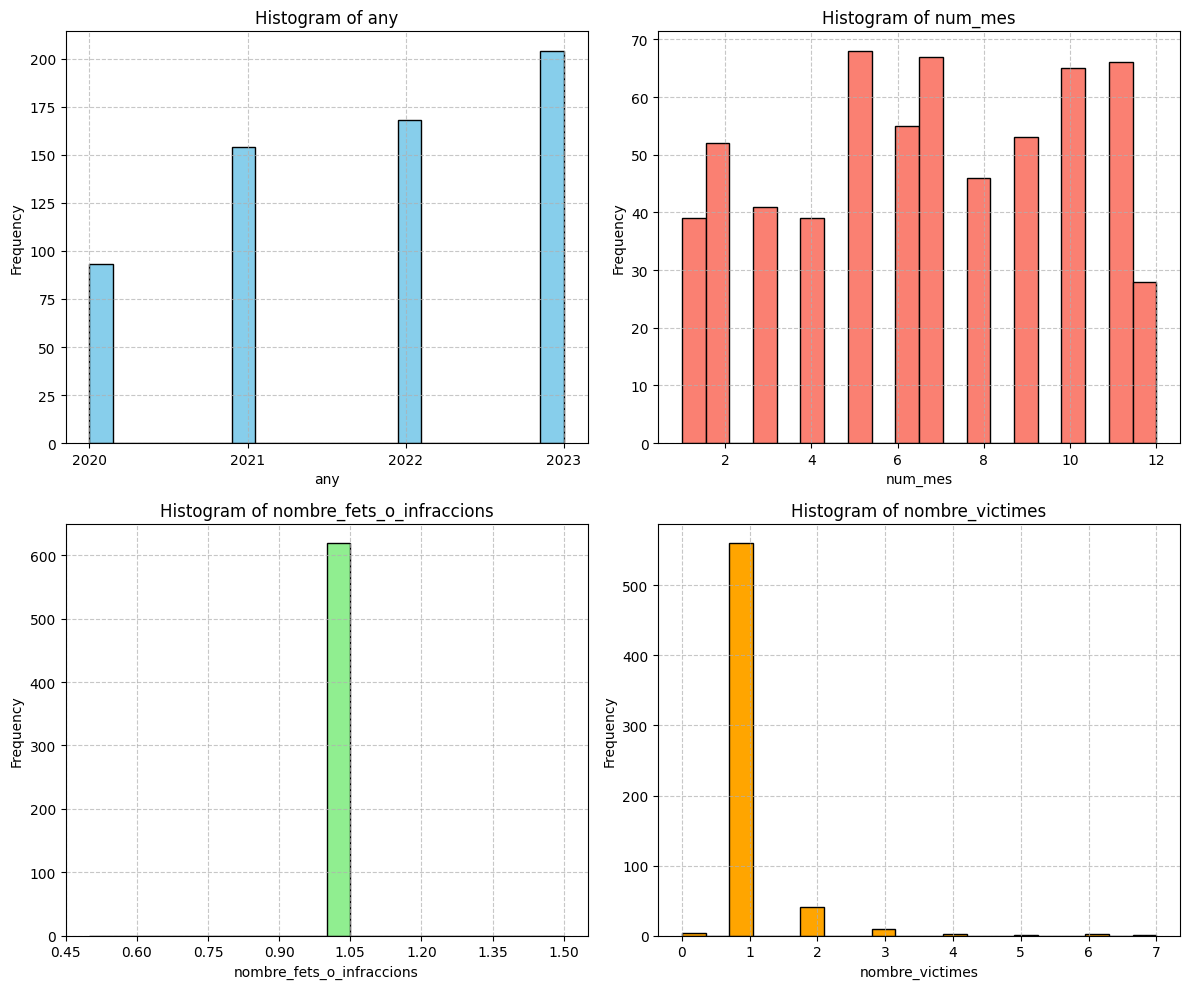

In [47]:
def plot_numeric_histograms(df):
    numeric_columns = ['any', 'num_mes', 'nombre_fets_o_infraccions', 'nombre_victimes']
    colors = ['skyblue', 'salmon', 'lightgreen', 'orange']
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))  
    axs = axs.flatten()  
    
    for i, column in enumerate(numeric_columns):
        column_data = df.select(column).rdd.flatMap(lambda x: x).collect()

        if column_data:
            ax = axs[i] 
            frequencies, bins, _ = ax.hist(column_data, bins=20, color=colors[i], edgecolor='black')
            ax.set_title(f'Histogram of {column}')
            ax.set_xlabel(column)
            ax.set_ylabel('Frequency')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
    plt.tight_layout()
    plt.show()

plot_numeric_histograms(df_filtered)

In [48]:
# Remove redundant col --> nombre_fets_o_infraccions
df_filtered = df_filtered.drop('nombre_fets_o_infraccions')

Categorical Features Distributions Insights:

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

+ Examining the `"area_basica_policial"` variable reveals technical data cleaning improvements where the `"Ciutat Vella"` basic police area is inconsistently spelled in uppercase and lowercase → unify.
- Interestingly, `"Eixample"` and `"Ciutat Vella"` are the regions where hate crimes occur most frequently.
- The `"tipus_de_fet"` variable indicates that the majority of incidents are crimes, but the variable itself is redundant for our study → drop.
- The `"ambit_fet"` feature indicates the type of crime, with hate crimes based on LGTBI-fobia standing out significantly with a much higher ratio than others.
- The `"canal_dels_fets"` variable indicates whether incidents were reported through social channels or in person. Since our study focuses on street incidents in Barcelona, non-face-to-face criminal acts will not be considered.
</div>

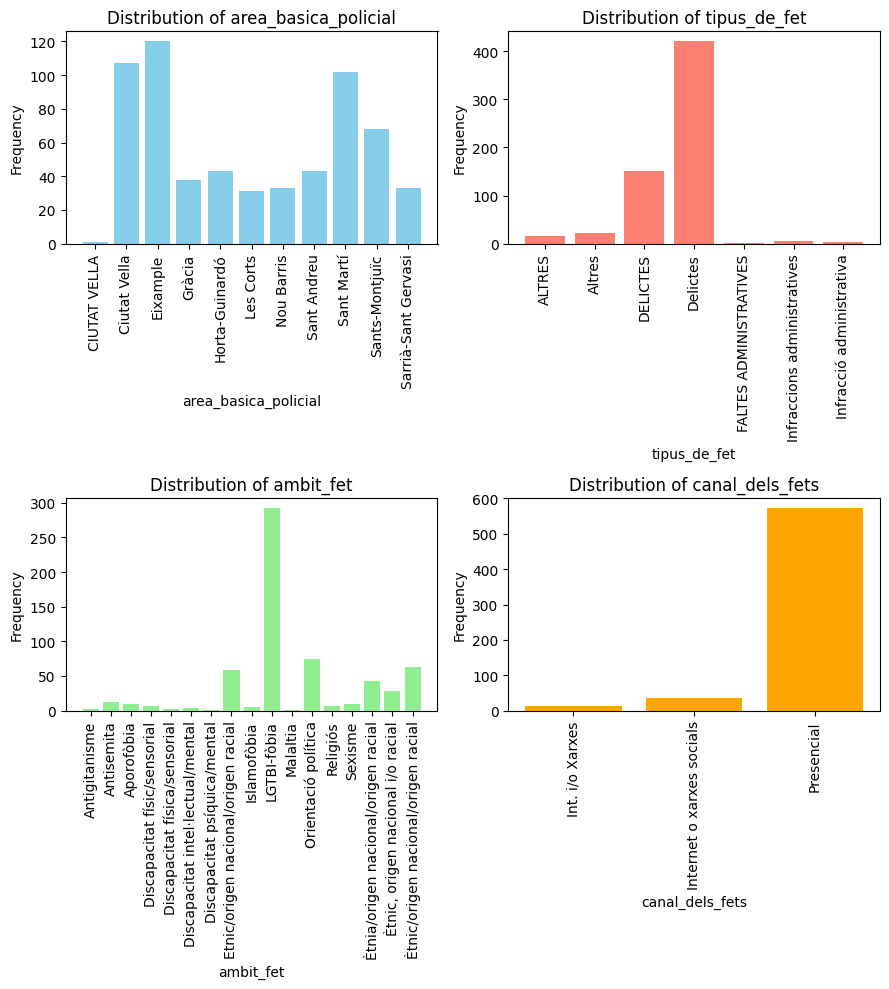

In [49]:
def plot_categorical_distribution(df, column, ax, color):
    counts = df.groupBy(column).count().orderBy(column).collect()
    labels = [row[column] for row in counts]
    frequencies = [row['count'] for row in counts]
    ax.bar(labels, frequencies, color=color)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {column}')
    ax.tick_params(axis='x', rotation=90)

# Categorical features 
categorical_columns = ['area_basica_policial', 'tipus_de_fet', 'ambit_fet', 'canal_dels_fets']

fig, axs = plt.subplots(2, 2, figsize=(9, 10))  
axs = axs.flatten()  # Aplanar la matriz de subplots
color_palette = ['skyblue', 'salmon', 'lightgreen', 'orange'] # Paleta de colores

for i, column in enumerate(categorical_columns):
    ax = axs[i]  
    color = color_palette[i % len(color_palette)]  
    plot_categorical_distribution(df_filtered, column, ax, color)

plt.tight_layout()
plt.show()

In [50]:
## Unify the col values in English for visualization
df_filtered.select("ambit_fet").distinct().show()

value_translation = {
    "Discapacitat psíquica/mental": "Psychological disability",
    "Discapacitat intel·lectual/mental": "Intellectual disability",
    "Orientació política": "Political orientation",
    "Ètnic/origen nacional/origen racial": "Ethnic/national/racial origin",
    "Sexisme": "Sexism",
    "Discapacitat física/sensorial": "Physical/sensory disability",
    "Discapacitat físic/sensorial": "Physical/sensory disability",    
    "Aporofòbia": "Aporophobia",
    "Discapacitat física/sensorial": "Physical/sensory disability",
    "Islamofòbia": "Islamophobia",
    "Ètnia/origen nacional/origen racial": "Ethnic/national/racial origin",
    "Etnic/origen nacional/origen racial": "Ethnic/national/racial origin",
    "Antisemita": "Antisemitism",
    "LGTBI-fòbia": "LGBTI-phobia",
    "Antigitanisme": "Anti-gypsyism",
    "Ètnic, origen nacional i/o racial": "Ethnic/national/racial origin",
    "Malaltia": "Illness",
    "Religiós": "Religious"
}

for original, translated in value_translation.items():
    df_filtered = df_filtered.withColumn("ambit_fet", when(df_filtered["ambit_fet"] == original, translated).otherwise(df_filtered["ambit_fet"]))
df_filtered.select("ambit_fet").distinct().show()

+--------------------+
|           ambit_fet|
+--------------------+
|Discapacitat psíq...|
|Discapacitat inte...|
| Orientació política|
|Ètnic/origen naci...|
|             Sexisme|
|Discapacitat físi...|
|          Aporofòbia|
|Discapacitat físi...|
|         Islamofòbia|
|Ètnia/origen naci...|
|Etnic/origen naci...|
|          Antisemita|
|         LGTBI-fòbia|
|       Antigitanisme|
|Ètnic, origen nac...|
|            Malaltia|
|            Religiós|
+--------------------+

+--------------------+
|           ambit_fet|
+--------------------+
|Ethnic/national/r...|
|        Antisemitism|
|        Islamophobia|
|Intellectual disa...|
|Political orienta...|
|        LGBTI-phobia|
|       Anti-gypsyism|
|Psychological dis...|
|         Aporophobia|
|           Religious|
|Physical/sensory ...|
|             Illness|
|              Sexism|
+--------------------+



Categorical Data Cleaning

In [51]:
# Replace Ciutat Vella uppercase
df_filtered = df_filtered.withColumn("area_basica_policial", 
                                     regexp_replace(df_filtered["area_basica_policial"], 
                                      "CIUTAT VELLA",   "Ciutat Vella"))

df_filtered = df_filtered.drop('tipus_de_fet')

# Filter the data to keep only the values where canals_dels_fets == "Presencial"
df_filtered = df_filtered.filter(df_filtered["canal_dels_fets"] == "Presencial")

# Drop canals_dels_fets --> Redundant
df_filtered = df_filtered.drop('canal_dels_fets')

Textual Features  Insights -- Word Cloud

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

+ The variable `titol_de_fet_codi_penal` is not relevant for visualizing the results for our study -- Legislative
+ `Tipus de codi penal` requires preprocessing before the variable can be useful for the study
+ `Tipus de lloc dels fets`clearly highlights that the majority of crimes occur in public places, also inside residential premises (apartments, houses), as well as in building entrances or public transport.
</div>


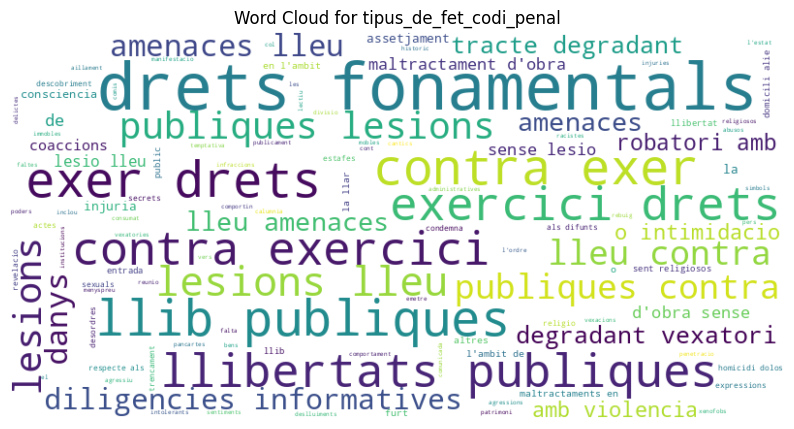

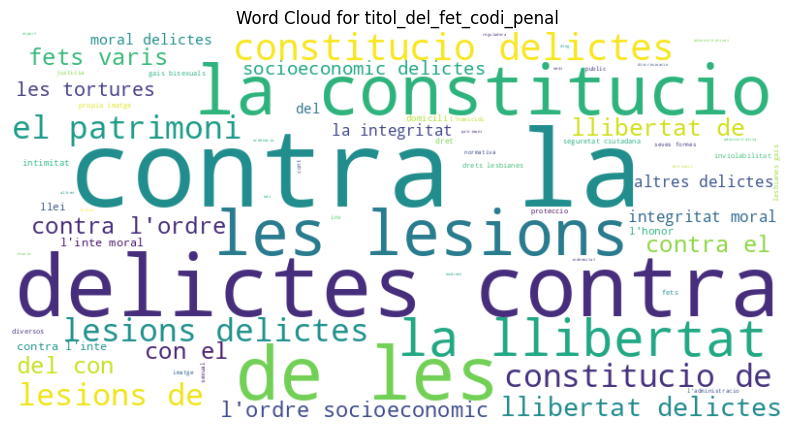

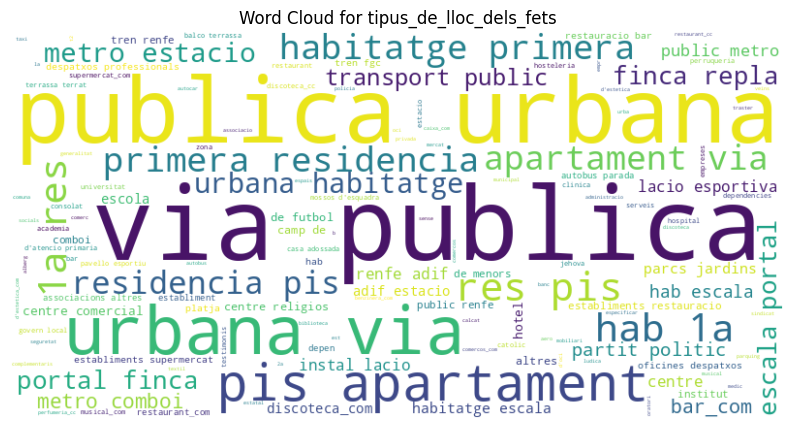

In [52]:
def generate_word_cloud(values, title):
    text = " ".join(unidecode(value).lower() for value in values) # Unifquem en minuscuels y sense accents x treure + insides
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Textual cols
columns_and_titles = {
    "tipus_de_fet_codi_penal": "Word Cloud for tipus_de_fet_codi_penal",
    "titol_del_fet_codi_penal": "Word Cloud for titol_del_fet_codi_penal",
    "tipus_de_lloc_dels_fets": "Word Cloud for tipus_de_lloc_dels_fets"
}

for column, title in columns_and_titles.items():
    values = df_filtered.select(column).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
    generate_word_cloud(values, title)

In [53]:
# Remove redundant col --> nombre_fets_o_infraccions
df_filtered = df_filtered.drop('titol_del_fet_codi_penal')

In [54]:
# Preprocessing --> tipus_de_lloc_dels_fets
tipus_de_lloc_dels_fets_values = df_filtered.select("tipus_de_lloc_dels_fets").rdd.flatMap(lambda x: x).filter(lambda x: x is  None).collect()
tipus_de_lloc_dels_fets_values # Nomes hi ha un none drop la mostra

[None]

In [55]:
df_filtered = df_filtered.filter(df_filtered.tipus_de_lloc_dels_fets.isNotNull())

In [56]:
df_criminal = df_filtered
df_criminal.limit(2).toPandas() 

,any,num_mes,nom_mes,area_basica_policial,tipus_de_lloc_dels_fets,tipus_de_fet_codi_penal,ambit_fet,nombre_victimes
0,2021,6,Juny,Nou Barris,Via pública urbana,Amenaces,Political orientation,1.0
1,2020,1,Gener,Eixample,Zona d'oci/lúdica,Robatori amb violència i/o intimidació,LGBTI-phobia,1.0


<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
        <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold; color: black;">
            Airbnb Dataset
        </span>
    </div>
</div>

#### DataFrame Schema

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
The DataFrame comprises various groups of columns, each providing distinct details related to property listings:

- The DataFrame has **9999 rows** and **54 columns**.

**Property Information:**
- **name:** A string indicating the name of the property.
- **summary:** A string providing a brief overview of the property.
- **space:** A string describing the available space within the property.
- **neighborhood_overview:** A string offering insights into the neighborhood surrounding the property.
- **notes:** Additional notes or remarks about the property.

**Host Information:**
- **host_id:** An identifier for the host of the property.
- **host_name:** The name of the host.
- **host_since:** The date when the host joined the platform.
- **host_location:** The location of the host.
- **host_about:** Information or description about the host.

**Host Response Details:**
- **host_response_time:** The typical response time of the host.
- **host_response_rate:** The rate of responses from the host, represented as a double.
- **host_verifications:** Methods used to verify the host's identity.

**Location Details:**
- **street:** The street address of the property.
- **neighbourhood:** The name of the neighborhood where the property is located.
- **latitude:** The latitude coordinate of the property.
- **longitude:** The longitude coordinate of the property.

**Property Details:**
- **property_type:** The type or category of the property.
- **room_type:** The type of room available in the property (e.g., entire home, private room, shared room).
- **accommodates:** The maximum number of guests the property can accommodate, represented as a decimal.
- **bathrooms:** The number of bathrooms in the property, represented as a double.
- **bedrooms:** The number of bedrooms in the property, represented as a double.
- **beds:** The number of beds available in the property, represented as a double.
- **bed_type:** The type of bed(s) available in the property.
</div>


Remove Redundant Columns:

These following columns are being removed due to their limited relevance in predicting Airbnb rental prices, as they either provide redundant information:

- neighbourhood: The neighborhood is being removed due to redundancy with Latitude and Longitude.
- Name: Name does not provide relevant information.
- summary, space, neighborhood_overview, notes, access, interaction, house_rules: These attributes are subjective and difficult to quantify, making them unsuitable as predictors of rental price.
- host_id, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_verifications: Host information does not directly influence rental price.
street: The specific property address is not a direct predictor of rental price.
weekly_price, monthly_price, minimum_nights, maximum_nights, availability_30, availability_60, availability_90, availability_365, number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_value, reviews_per_month: These attributes are not relevant for predicting rental price or are difficult to quantify.
- features, id: They do not provide relevant information for predicting rental price.


In [254]:
df_airbnb = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_airbnb_listings") \
  .load()

df_airbnb.limit(1).toPandas()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,cancellation_policy,calculated_host_listings_count,reviews_per_month,features,geolocation.lon,geolocation.lat,__index_level_0__
0,14618223,https://www.airbnb.com/rooms/14618223,20170407214050,2017-04-08,Piso cerca del Cam Nou,Acogedor y juvenil piso bien comunicado y en u...,Somos 2 chicos jóvenes y trabajadores que segu...,Acogedor y juvenil piso bien comunicado y en u...,none,None,El precio publicado es por habitacion,Tenemos a 3' las lineas 5 de metro (conectada ...,"Tendrás acceso a la cocina, baño y zonas comunes",None,None,None,None,NaN,None,38925857,https://www.airbnb.com/users/show/38925857,Javier,2015-07-19,"Toledo, Castile-La Mancha, Spain","Muy aficionado al deporte, practico casi cualq...",within a day,60.0,NaN,https://a0.muscache.com/im/pictures/c4b46d10-2...,https://a0.muscache.com/im/pictures/c4b46d10-2...,None,1.0,1.0,"email, phone, reviews, jumio","Barcelona, CT 08028, Spain",None,la Maternitat i Sant Ramon,Les Corts,Barcelona,CT,08028,Barcelona,"Barcelona, Spain",ES,Spain,41.378150177192396,2.122075545481956,Apartment,Private room,2,2.0,1.0,2.0,Real Bed,"TV, Internet, Wireless Internet, Kitchen, Elev...",None,21.0,NaN,NaN,NaN,NaN,1,7,1,1125,yesterday,NaN,0,4,34,309,2017-04-07,1,2016-08-22,2016-08-22,100.0,10.0,10.0,10.0,10.0,10.0,10.0,None,NaN,moderate,1,0.13,"Host Has Profile Pic, Host Identity Verified, ...",2.122076,41.37815,0


In [255]:
columns_to_drop = [ 'neighbourhood', "Name", "summary", "space", 'neighborhood_overview', 'notes', 'access', 'interaction', 'house_rules', 'host_id', 'host_name', 'host_since', 
                   'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_verifications', 'street', 'weekly_price', 'monthly_price', 'minimum_nights', 
                   'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                   'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'reviews_per_month', 'features', 'id', "listing_url", 
                   "Description", "experiences_offered", "scrape_id", "last_scraped", "jurisdiction_names", "thumbnail_url", "host_acceptance_rate", "host_thumbnail_url",
                   "host_picture_url", "xl_picture_url","picture_url", "host_thumbnail_url", "host_neighbourhood", "host_url", "medium_url", "host_listings_count", "host_total_listings_count", 
                   "__index_level_0__", "state", "license", "calendar_last_scraped", "calculated_host_listings_count", "first_review", "last_review", "has_availability", "calendar_updated"]

df_airbnb = df_airbnb.drop(*columns_to_drop)
df_airbnb.limit(1).toPandas()

,transit,neighbourhood_cleansed,neighbourhood_group_cleansed,city,zipcode,market,smart_location,country_code,country,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,review_scores_location,review_scores_value,cancellation_policy,geolocation.lon,geolocation.lat
0,Tenemos a 3' las lineas 5 de metro (conectada ...,la Maternitat i Sant Ramon,Les Corts,Barcelona,08028,Barcelona,"Barcelona, Spain",ES,Spain,41.378150177192396,2.122075545481956,Apartment,Private room,2,2.0,1.0,2.0,Real Bed,"TV, Internet, Wireless Internet, Kitchen, Elev...",None,21.0,NaN,NaN,1,7,10.0,10.0,moderate,2.122076,41.37815


Location Features Unification

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">
All the apartments are located in Barcelona. 

- Remove the redundant cols in location stage that are the same: `['market', "city", "smart_location", "country", "country_code", "zipcode", ]
    
    - `Market`: Remove the ones that are not in Barcelona.
    - `Country` and `City`: Remove because they are the same. 
    - `Zip Code`: Redundance because it is the same as Geolocation data. 
    - `geolocation.lon`, `geolocation.lat`: Remove because has same information than `Latitud`, `Longitud`.
        - Are the same values?  Relation data `neighbourhood` features & `criminal_dataset`
    - `neighbourhood_cleansed`: Remove because has same informatin as `Latitud`, `Longitud`.
    - `neighbourhood_group_cleansed`: Keep in order to match with criminal dataset. Change name to `neighbourhood`.
</div>

In [256]:
# Remove instances market is not Barcelona
df_airbnb.select("market").distinct().show()
df_airbnb = df_airbnb.filter(df_airbnb['market'] == 'Barcelona')

+----------------+
|          market|
+----------------+
|       Barcelona|
|    Buenos Aires|
|Costa Brava Nord|
|        Valencia|
|            NULL|
+----------------+



In [257]:
df_airbnb.select("city").distinct().show()
df_airbnb.select("smart_location").distinct().show()
df_airbnb.select("country").distinct().show()
df_airbnb.select("country_code").distinct().show()

columns_to_drop = ["city", "zipcode", "smart_location", "country", "country_code", "market", 'neighbourhood_cleansed']
df_airbnb = df_airbnb.drop(*columns_to_drop)

+---------+
|     city|
+---------+
|Barcelona|
|barcelona|
+---------+

+-----------------+
|   smart_location|
+-----------------+
|Barcelona , Spain|
| barcelona, Spain|
| Barcelona, Spain|
|barcelona , Spain|
+-----------------+

+-------+
|country|
+-------+
|  Spain|
+-------+

+------------+
|country_code|
+------------+
|          ES|
+------------+



In [258]:
# Location change name -- solving text issues
df = df.rename(columns={'neighbourhood_group_cleansed': 'neighbourhood'})
column_mapping = dict(zip(df_airbnb.columns[-2:], ["geolocation_lon", "geolocation_lat"]))

for old_name, new_name in column_mapping.items():
    df_airbnb = df_airbnb.withColumnRenamed(old_name, new_name)

location = df_airbnb.select("geolocation_lon", "geolocation_lat", "latitude", "longitude").limit(5)
location.show()

# Same values -- Drop geolocation_lon and geolocation_lon
columns_to_drop = ["geolocation_lon", "geolocation_lat"]
df_airbnb = df_airbnb.drop(*columns_to_drop)

+------------------+------------------+------------------+------------------+
|   geolocation_lon|   geolocation_lat|          latitude|         longitude|
+------------------+------------------+------------------+------------------+
| 2.122075545481956|41.378150177192396|41.378150177192396| 2.122075545481956|
|2.1049250609405097|  41.4148655885311|  41.4148655885311|2.1049250609405097|
|2.1407658129075626|41.410925919974986|41.410925919974986|2.1407658129075626|
|2.1578867703448044| 41.40097836628479| 41.40097836628479|2.1578867703448044|
| 2.208579360995987| 41.42119449770243| 41.42119449770243| 2.208579360995987|
+------------------+------------------+------------------+------------------+



NULL Values 

<div class="alert alert-block alert-warning" style="color: #C23B22; background-color: #f8c3c0;">

- `square_feet`: Remove because has a wide range of Null values.
- `security deposit` & `cleaning_fee`: Replace the NULL to 0 (assumed that there are 0).
</div>


In [259]:
nan_counts = df_airbnb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_airbnb.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,transit,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,review_scores_location,review_scores_value,cancellation_policy
0,4033,0,0,0,0,0,0,16,11,21,0,0,9622,20,5128,3532,0,0,2092,2095,0


In [260]:
# Data Cleaning for NULL values
df_airbnb = df_airbnb.drop('square_feet')
df_airbnb = df_airbnb.drop('transit')
df_airbnb = df_airbnb.fillna({'security_deposit': 0})
df_airbnb = df_airbnb.fillna({'cleaning_fee': 0})

In [226]:
# Checking again the NULL values
nan_counts = df_airbnb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_airbnb.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,review_scores_location,review_scores_value,cancellation_policy
0,3561,0,0,0,0,0,16,11,21,0,0,20,0,0,0,0,2092,2095,0


<div class="alert alert-block alert-warning" style="color: #C23B22; background-color: #f8c3c0;">

- **Majority of NULLs resolved**
- `bedrooms` (9 samples) and `beds` (16 samples): Manual handling required.
- `price` (7 samples): Manual handling required.
</div>

In [261]:
# Replacing missing values in review score location with review_scores_value
df_airbnb = df_airbnb.withColumn('review_scores_location', when(col('review_scores_location').isNull(), col("review_scores_value")).otherwise(col('review_scores_location')))
df_airbnb = df_airbnb.drop('review_scores_value')

In [262]:
df_airbnb = df_airbnb.filter(col("price").isNotNull()) # Not extract information from other columns

Handling Missing Values of `bathrooms`, `bedrooms` y `beds`

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
+ Manual Processing for each feature looking to other values.
</div>

In [263]:
df_airbnb = df_airbnb.withColumn("id", monotonically_increasing_id())

`bedrooms`

In [265]:
null_prices = df_airbnb.filter(df_airbnb['bedrooms'].isNull())
null_prices.toPandas().iloc[0] # Beedrooms --> 1 --> id: 340
null_prices.toPandas().iloc[1] # Beedrooms --> 1, bed --> 1 --> id:8589934645
null_prices.toPandas().iloc[2] # Beedrooms --> 1, bed --> 2 ---> id:8589935428
null_prices.toPandas().iloc[3] # Beedrooms --> 1, bed --> 1 ---> id:17179869227
null_prices.toPandas().iloc[4] # Beedrooms --> 3, id:25769804406
null_prices.toPandas().iloc[5] # Beedrooms --> 1, id:17179869830
null_prices.toPandas().iloc[6] # Beedrooms --> 1, bed --> 1, id:34359739217
null_prices.toPandas().iloc[7] # Beedrooms --> 1 --> id:42949673002

neighbourhood_group_cleansed                                         Ciutat Vella
latitude                                                       41.383770307403466
longitude                                                      2.1793069860397076
property_type                                                         Condominium
room_type                                                            Private room
accommodates                                                                    1
bathrooms                                                                     1.0
bedrooms                                                                      NaN
beds                                                                          NaN
bed_type                                                                 Real Bed
amenities                       Wireless Internet, Air conditioning, Kitchen, ...
price                                                                        35.0
security_deposit

`beds`

In [266]:
null_beds = df_airbnb.filter(df_airbnb['beds'].isNull())
null_beds.toPandas().iloc[0] # bed --> 1 id: 468
null_beds.toPandas().iloc[1] # bed --> 1 id: 8589935377
null_beds.toPandas().iloc[2] # bed --> 1 id: 17179869602
null_beds.toPandas().iloc[3] # bed --> 1, bathroom --> 1  id: 25769804176
null_beds.toPandas().iloc[4] # bed --> 1, bathroom --> 1  id: 34359738631
null_beds.toPandas().iloc[5] # bed --> 3, bathroom --> 2  id: 34359738928
null_beds.toPandas().iloc[6] # bed --> 1  id: 42949673153
null_beds.toPandas().iloc[7] # bed --> 1  id: 42949673810
null_beds.toPandas().iloc[8] # bed --> 1  id: 51539608080
null_beds.toPandas().iloc[9] # bed --> 1  id: 51539608320

neighbourhood_group_cleansed                                             Eixample
latitude                                                        41.40682313490898
longitude                                                      2.1785930223863152
property_type                                                           Apartment
room_type                                                            Private room
accommodates                                                                    2
bathrooms                                                                     1.0
bedrooms                                                                      1.0
beds                                                                          NaN
bed_type                                                                 Real Bed
amenities                       Wireless Internet, Kitchen, Smoking allowed, H...
price                                                                        40.0
security_deposit

`bathrooms`

In [231]:
null_bathrooms = df_airbnb.filter(df_airbnb['bathrooms'].isNull())
null_bathrooms.toPandas().iloc[0] # bathrooms --> 2 id:149
null_bathrooms.toPandas().iloc[1] # bathrooms --> 1 id:17179869331
null_bathrooms.toPandas().iloc[2] # bathrooms --> 1 id:25769804030
null_bathrooms.toPandas().iloc[3] # bathrooms --> 1 id:42949673312
null_bathrooms.toPandas().iloc[4] # bathrooms --> 1 id:51539607636
null_bathrooms.toPandas().iloc[5] # bathrooms --> 1 id:51539607684
null_bathrooms.toPandas().iloc[6] # bathrooms --> 3 id:51539607896
null_bathrooms.toPandas().iloc[7] # bathrooms --> 1 id:60129542275

neighbourhood                                              El Baix Guinardó
latitude                                                  41.41128022309318
longitude                                                 2.168638814317621
property_type                                                     Apartment
room_type                                                      Private room
accommodates                                                              2
bathrooms                                                               NaN
bedrooms                                                                1.0
beds                                                                    1.0
bed_type                                                           Real Bed
amenities                 TV, Internet, Wireless Internet, Kitchen, Elev...
price                                                                  47.0
security_deposit                                                        0.0
cleaning_fee

In [267]:
ids_and_values = [
    (340, {"bedrooms": 1}),
    (8589934645, {"bedrooms": 1, "beds": 1}),
    (8589935428, {"bedrooms": 1, "beds": 2}),
    (17179869227, {"bedrooms": 1, "beds": 1}),
    (25769804406, {"bedrooms": 3}),
    (17179869830, {"bedrooms": 1}),
    (34359739217, {"bedrooms": 1, "beds": 1}),
    (42949673002, {"bedrooms": 1}),
    (468, {"beds": 1}),
    (8589935377, {"beds": 1}),
    (17179869602, {"beds": 1}),
    (25769804176, {"beds": 1, "bathrooms": 1}),
    (34359738631, {"beds": 1, "bathrooms": 1}),
    (34359738928, {"beds": 3, "bathrooms": 2}),
    (42949673153, {"beds": 1}),
    (42949673810, {"beds": 1}),
    (51539608080, {"beds": 1}),
    (51539608320, {"beds": 1}),
    (149, {"bathrooms": 2}),
    (17179869331, {"bathrooms": 1}),
    (25769804030, {"bathrooms": 1}),
    (42949673312, {"bathrooms": 1}),
    (51539607636, {"bathrooms": 1}),
    (51539607684, {"bathrooms": 1}),
    (51539607896, {"bathrooms": 3}),
    (60129542275, {"bathrooms": 1})
]

for id, values in ids_and_values:
    if "bedrooms" in values:
        df_airbnb = df_airbnb.withColumn("bedrooms", when(df_airbnb["id"] == id, values["bedrooms"]).otherwise(df_airbnb["bedrooms"]))
    if "beds" in values:
        df_airbnb = df_airbnb.withColumn("beds", when(df_airbnb["id"] == id, values.get("beds", df_airbnb["beds"])).otherwise(df_airbnb["beds"]))
    if "bathrooms" in values:
        df_airbnb = df_airbnb.withColumn("bathrooms", when(df_airbnb["id"] == id, values.get("bathrooms", df_airbnb["bathrooms"])).otherwise(df_airbnb["bathrooms"]))

In [268]:
# Checking again the NULL values
nan_counts = df_airbnb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_airbnb.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,review_scores_location,cancellation_policy,id
0,0,0,0,0,0,0,16,11,21,0,0,0,0,0,0,0,2078,0,0


<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
+ NULL values == 0
</div>

Categorical Features Distributions Insights

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

+ All features have been processed; no further data cleaning is required.
+ The majority of cancellation policies are strict.
+ There are three types of accommodations: entire apartments, private rooms within an apartment (with a amount similar to entire apartments), and a few samples of shared rooms.
</div>

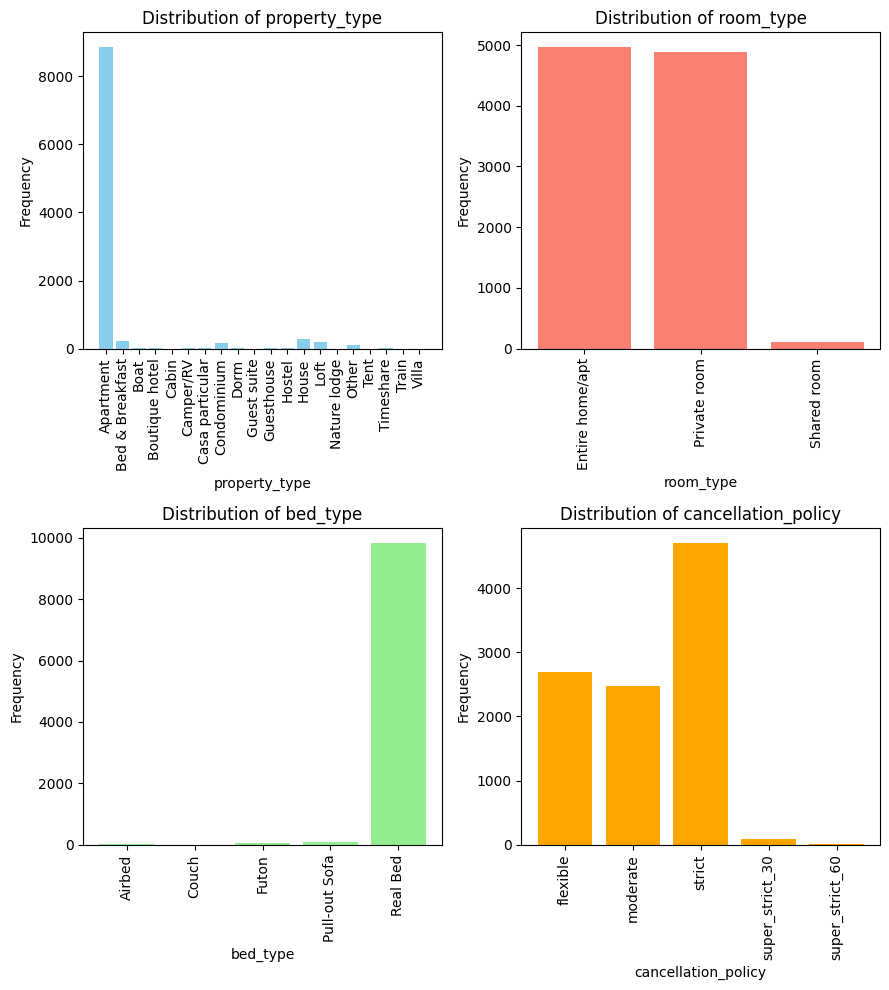

In [269]:
# Categorical features 
categorical_columns = ['property_type',	'room_type','bed_type', 'cancellation_policy']

fig, axs = plt.subplots(2, 2, figsize=(9, 10))  
axs = axs.flatten() 

for i, column in enumerate(categorical_columns):
    ax = axs[i]  
    color = color_palette[i % len(color_palette)]  
    plot_categorical_distribution(df_airbnb, column, ax, color)

plt.tight_layout()
plt.show()

Sampling and Mapping Airbnb Listings in Barcelona

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">

+ A sample of the Airbnb dataset is being visualized on a map of Barcelona.
    + Due to rendering constraints, only a subset of the data is displayed.
+ Each marker represents a listing, with its location indicated by latitude and longitude coordinates.
+ The map is centered on Barcelona, providing an overview of the spatial distribution of Airbnb listings in the city. Distibuted locations.
</div>

Replace Concellation_policy for dummy variable: 

- Unique values: [flexible, super_strict_60, strict, super_strict_30, moderate]

In [270]:
def create_dummies_variables(column, df=df_airbnb):
    unique_values = [row[column] for row in df.select(column).distinct().collect()]

    for unique_value in unique_values:
        column_name = 'has_' + str(unique_value).replace(' ', '_')
        df = df.withColumn(column_name, when(col(column) == unique_value, 1).otherwise(0))
    df = df.drop(column)
    return df

In [271]:
[row[column] for row in df_airbnb.select('cancellation_policy').distinct().collect()]
df_airbnb = create_dummies_variables('cancellation_policy', df_airbnb)

Add index_criminality for neighbourhood

In [275]:
from pyspark.sql.functions import col, lit, create_map, when

def calculate_index_criminality(df_criminal, df, column):
    neighbourhoods = [row['area_basica_policial'] for row in df_criminal.select('area_basica_policial').distinct().collect()]
    total_crimes = df_criminal.count()
    total_crimes_per_neighbourhood = {neighbourhood: 0 for neighbourhood in neighbourhoods}

    for neighbourhood in neighbourhoods:
        crimes_in_neighbourhood = df_criminal.filter(col('area_basica_policial') == neighbourhood).count()
        if total_crimes > 0: 
            total_crimes_per_neighbourhood[neighbourhood] = crimes_in_neighbourhood / total_crimes

    mapping_expr = create_map(*[item for sublist in [[lit(k), lit(v)] for k, v in total_crimes_per_neighbourhood.items()] for item in sublist])
    df = df.withColumn('index_criminality', mapping_expr.getItem(col(column)))
    df = df.drop(column)
    return df

In [276]:
df_airbnb = calculate_index_criminality(df_criminal, df_airbnb, 'neighbourhood')

,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,review_scores_location,id,has_flexible,has_super_strict_60,has_strict,has_super_strict_30,has_moderate,index_criminality
0,41.378150177192396,2.122075545481956,Apartment,Private room,2,2.0,1.0,2.0,Real Bed,"TV, Internet, Wireless Internet, Kitchen, Elev...",21.0,0.0,0.0,1,7,10.0,0,0,0,0,0,1,0.050788


<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
        <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold; color: black;">
            TripAdvisor Locations Dataset
        </span>
    </div>
</div>


#### DataFrame Schema

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
The DataFrame comprises various columns, each providing distinct details related to property listings:

The DataFrame has **2493 rows** and **14 columns**. 

- **location_id**: string (nullable = true)
- **name**: string (nullable = true)
- **distance**: string (nullable = true)
- **bearing**: string (nullable = true)
- **address_obj.street1**: string (nullable = true)
- **address_obj.city**: string (nullable = true)
- **address_obj.state**: string (nullable = true)
- **address_obj.country**: string (nullable = true)
- **address_obj.postalcode**: string (nullable = true)
- **address_obj.address_string**: string (nullable = true)
- **address_obj.street2**: string (nullable = true)
- **type**: string (nullable = true)
- **district**: string (nullable = true)
- **__index_level_0__**: decimal(20,0) (nullable = true)
</div>

In [281]:
df_locations = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_tripadvisor_locations") \
  .load()

Replace names with points

In [287]:
exprs = [f"`{col_name}` as `{col_name.replace('.', '_')}`" for col_name in df_locations.columns]
df_locations = df_locations.selectExpr(exprs)

print("The DataFrame has {} rows and {} columns. \n".format(df_locations.count(), len(df_locations.columns)))

The DataFrame has 2493 rows and 14 columns. 



Count Null Values

In [288]:
nan_counts = df_locations.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_locations.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,location_id,name,distance,bearing,address_obj_street1,address_obj_city,address_obj_state,address_obj_country,address_obj_postalcode,address_obj_address_string,address_obj_street2,type,district,__index_level_0__
0,0,0,0,0,47,0,1,0,106,0,1864,0,0,0


Remove redundant columns

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

+ `distance`used on data collectors --> Redundant now
+ `bearning` is Compass bearing from the reference point to said apartment. --> Redudant now
+ `address_obj.street2`, `address_obj_postalcode` --> No need we will have the geolocation
+ `__index_level_0__` --> New index after changes
+ `address_obj.street1` (have NULLS) --> More information in `address_obj.address_string`  (No NULLS)--> only for retriving the geolocation data
+ Only keep the values located in Barcelona --> Then, the variable `address_obj_city` == Redundant
</div>



In [289]:
df_locations.select("address_obj_city").distinct().show()
df_locations = df_locations.filter(df_locations['address_obj_city'] == 'Barcelona')

+--------------------+
|    address_obj_city|
+--------------------+
|              Xativa|
|          Ibiza Town|
|             Peguera|
|Sant Cugat del Va...|
|Sant Andreu de la...|
|            Sabadell|
|           Barcelona|
|   Montcada i Reixac|
|              Sitges|
|L'Hospitalet de L...|
|          La Bordeta|
|            Valencia|
|         Los Abrigos|
|               Cadiz|
|Sant Feliu de Llo...|
+--------------------+



In [290]:
columns_to_drop = ["distance", "bearing", "address_obj_street2", "address_obj_postalcode", "__index_level_0__", "address_obj_street1", "address_obj_state", "address_obj_city", "address_obj_country" ]
df_locations = df_locations.drop(*columns_to_drop)

Geolocalization function

<div class="alert alert-block alert-info" style="color: #1E88E5; background-color: #B2EBF2;">

+ We've crafted a geolocation function called `geolocalization_with_retry` to pinpoint addresses using the **Google Maps API** and `address_obj_address_string` feature. This function has the ability to retry geolocation several times in case of initial failure due to errors or timeouts. If successful, it returns the latitude and longitude coordinates of the provided address.

+ We've implemented a mechanism to avoid re-executing the geolocation code for addresses that have already been matched. This is achieved by saving the geolocation results to a file (`coordinates_dict.pkl`) and loading them from there for subsequent executions, preventing unnecessary repetition of the geocoding process.


+ We plotted the geolocations to visually identify any outliers. Then, we defined a square area to limit the zone of Barcelona, excluding any points that fall outside of this area.

</div>


In [291]:
# As it takes too long, it will be saved to a file for separate loading
import requests
import time

def geolocalization_with_retry(address, retries=3, sleep_time=5):
    api_key = '{your_key ;)}'
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}"

    for attempt in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'OK':
                lat = data['results'][0]['geometry']['location']['lat']
                lng = data['results'][0]['geometry']['location']['lng']
                return (lat, lng)
        time.sleep(sleep_time)  # Espera antes de reintentar
    return None

In [292]:
file_name = "coordinates_dict.pkl"

# Load de retrieved dict
with open(file_name, "rb") as file:
    coordinates_dict = pickle.load(file)

In [293]:
df_coordenadas = spark.createDataFrame(list(coordinates_dict.items()), ['location_id', 'coordinates'])
df_locations = df_locations.join(df_coordenadas, on='location_id', how='left')

In [294]:
df_locations = df_locations \
    .withColumn('coordinates_str', concat_ws(',', col('coordinates._1'), col('coordinates._2'))) \
    .withColumn('latitude', split(col('coordinates_str'), ',').getItem(0).cast('float')) \
    .withColumn('longitude', split(col('coordinates_str'), ',').getItem(1).cast('float')) \
    .drop(*['coordinates_str', 'coordinates'])  

df_locations.limit(2).toPandas()

,location_id,name,address_obj_address_string,type,district,latitude,longitude
0,27200794,Anna Subirats Xarcuteria,"Carrer De Sepulveda, 167, 08011 Barcelona Spain",restaurant,Eixample,41.383205,2.162197
1,27326644,Rincon Del Cazador,"Passeig De La Mare De Deu Del Coll, 68, 08023 ...",restaurant,Gràcia,41.417217,2.147516


In [295]:
# Limits of Barcelona
barcelona_lat_min = 41.33
barcelona_lat_max = 41.45
barcelona_lng_min = 2.10
barcelona_lng_max = 2.24

map_barcelona = folium.Map(location=[(barcelona_lat_min + barcelona_lat_max) / 2,
                                     (barcelona_lng_min + barcelona_lng_max) / 2], zoom_start=12)

# Square to paint
bounds = [(barcelona_lat_min, barcelona_lng_min),
          (barcelona_lat_min, barcelona_lng_max),
          (barcelona_lat_max, barcelona_lng_max),
          (barcelona_lat_max, barcelona_lng_min),
          (barcelona_lat_min, barcelona_lng_min)]

folium.Polygon(bounds, color='red', fill=True, fill_color='red', fill_opacity=0.5).add_to(map_barcelona)
map_barcelona

In [296]:
# Apply the square
df_barcelona = df_locations[(df_locations['latitude'] >= barcelona_lat_min) & 
                            (df_locations['latitude'] <= barcelona_lat_max) &
                            (df_locations['longitude'] >= barcelona_lng_min) & 
                            (df_locations['longitude'] <= barcelona_lng_max)]

In [297]:
df_barcelona.select("type").distinct().show()
df_barcelona.select("district").distinct().show()
# rename district to match to the other dfs
df_barcelona = df_barcelona.withColumnRenamed("district", "neighbourhood")

+----------+
|      type|
+----------+
|attraction|
|restaurant|
+----------+

+-------------------+
|           district|
+-------------------+
|             Gràcia|
|         Sant Martí|
|     Horta-Guinardó|
|          Les Corts|
|     Sants-Montjuïc|
|         Nou Barris|
|Sarrià-Sant Gervasi|
|           Eixample|
|        Sant Andreu|
|       Ciutat Vella|
+-------------------+



Categorical Features Distributions Insights
<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

+ The majority of restaurants and attractions are located between Ciutat Vella and Example, where the highest volume of tourists is found.
+ We have slightly more restaurants than attractions, but the difference is fairly balanced.
</div>

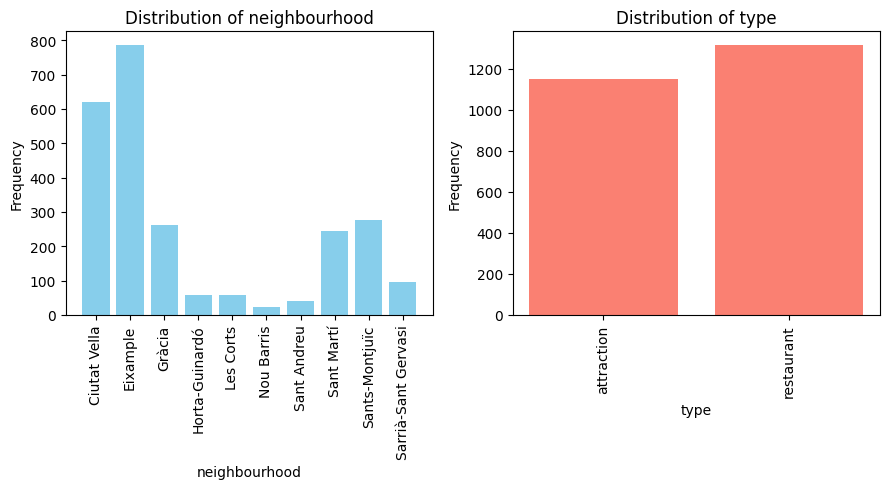

In [298]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))  
axs = axs.flatten() 

for i, column in enumerate(["neighbourhood", "type"]):
    ax = axs[i]  
    color = color_palette[i % len(color_palette)]  
    plot_categorical_distribution(df_barcelona, column, ax, color)

plt.tight_layout()
plt.show()

In [299]:
df_barcelona.printSchema()

root
 |-- location_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address_obj_address_string: string (nullable = true)
 |-- type: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
        <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold; color: black;">
            TripAdvisor Reviews Datasets
        </span>
    </div>
</div>



#### DataFrame Schema

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
The DataFrame comprises various columns, each providing distinct details related to property listings:

- The DataFrame has **5449 rows** and **48 columns**. 

- **location_id**: decimal(20,0) (nullable = true)
- **id**: decimal(20,0) (nullable = true)
- **lang**: string (nullable = true)
- **published_date**: string (nullable = true)
- **rating**: decimal(20,0) (nullable = true)
- **helpful_votes**: decimal(20,0) (nullable = true)
- **rating_image_url**: string (nullable = true)
- **url**: string (nullable = true)
- **text**: string (nullable = true)
- **title**: string (nullable = true)
- **trip_type**: string (nullable = true)
- **travel_date**: string (nullable = true)
- **user_username**: string (nullable = true)
- **user_user_location_id**: string (nullable = true)
- **user_avatar_thumbnail**: string (nullable = true)
- **user_avatar_small**: string (nullable = true)
- **user_avatar_medium**: string (nullable = true)
- **user_avatar_large**: string (nullable = true)
- **user_avatar_original**: string (nullable = true)
- **name**: string (nullable = true)
- **address_obj_address_string**: string (nullable = true)
- **type**: string (nullable = true)
- **neighbourhood**: string (nullable = true)
- **latitude**: float (nullable = true)
- **longitude**: float (nullable = true)
</div>


In [300]:
df_reviews = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_tripadvisor_reviews") \
  .load()

Replace names with points

In [303]:
exprs = [f"`{col_name}` as `{col_name.replace('.', '_')}`" for col_name in df_reviews.columns]
df_reviews = df_reviews.selectExpr(exprs)

Explanation for Join Operation

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

We are performing a join operation between `df_reviews` and `df_barcelona` DataFrames on the 'location_id' column. This is done to filter `df_reviews` to only include rows corresponding to locations that are present in `df_barcelona`. By using an inner join (`how='inner'`), we ensure that only matching rows from both DataFrames are retained, effectively restricting our analysis to reviews for locations within Barcelona.
</div>


In [304]:
df_reviews_barcelona = df_reviews.join(df_barcelona, on='location_id', how='inner')
print("The DataFrame has {} rows and {} columns. \n".format(df_reviews_barcelona.count(), len(df_reviews_barcelona.columns)))

The DataFrame has 5449 rows and 48 columns. 



Count the Null Values

In [305]:
nan_counts = df_reviews_barcelona.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_reviews_barcelona.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,location_id,id,lang,published_date,rating,helpful_votes,rating_image_url,url,text,title,trip_type,travel_date,user_username,user_user_location_id,user_user_location_name,user_avatar_thumbnail,user_avatar_small,user_avatar_medium,user_avatar_large,user_avatar_original,subratings_0_name,subratings_0_rating_image_url,subratings_0_value,subratings_0_localized_name,subratings_1_name,subratings_1_rating_image_url,subratings_1_value,subratings_1_localized_name,subratings_2_name,subratings_2_rating_image_url,subratings_2_value,subratings_2_localized_name,subratings_3_name,subratings_3_rating_image_url,subratings_3_value,subratings_3_localized_name,owner_response_id,owner_response_title,owner_response_text,owner_response_lang,owner_response_author,owner_response_published_date,name,address_obj_address_string,type,neighbourhood,latitude,longitude
0,0,0,0,0,0,0,0,0,0,0,34,34,0,0,1900,1,1,18,112,999,4311,4311,4311,4311,4322,4322,4322,4322,4346,4346,4346,4346,5070,5070,5070,5070,4973,4973,4973,4973,4973,4973,0,0,0,0,0,0


Remove redundant columns

<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

+ Values with lots of NaN --> drop
</div>

In [306]:
columns_to_drop = [
    "subratings_0_name",
    "subratings_0_rating_image_url",
    "subratings_0_value",
    "subratings_0_localized_name",
    "subratings_1_name",
    "subratings_1_rating_image_url",
    "subratings_1_value",
    "subratings_1_localized_name",
    "subratings_2_name",
    "subratings_2_rating_image_url",
    "subratings_2_value",
    "subratings_2_localized_name",
    "subratings_3_name",
    "subratings_3_rating_image_url",
    "subratings_3_value",
    "subratings_3_localized_name",
    "owner_response_id",
    "owner_response_title",
    "owner_response_text",
    "owner_response_lang",
    "owner_response_author",
    "owner_response_published_date",
    "user_user_location_name"
]
df_reviews_barcelona = df_reviews_barcelona.drop(*columns_to_drop)

In [308]:
## Prepare the DuckDB connection
con = duckdb.connect(database='./../data/trusted_zone/barcelona_processed.db', read_only=False)
con.close()

## Write on the tables 
print('Writting tables...')
jdbc_url = 'jdbc:duckdb:./../data/trusted_zone/barcelona_processed.db'
driver = "org.duckdb.DuckDBDriver"

print('    - Aribnb table')
df_airbnb.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_airbnb_listings") \
    .option("driver", driver) \
    .save()

print('    - Criminal table')
df_criminal.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_criminal_dataset") \
    .option("driver", driver) \
    .save()

print('    - Tripadvisor Locations table')
df_barcelona.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_tripadvisor_locations") \
    .option("driver", driver) \
    .save()

print('    - Tripadvisor Reviews table')
df_reviews_barcelona.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_tripadvisor_reviews") \
    .option("driver", driver) \
    .save()

spark.stop()

Writting tables...
    - Aribnb table


AnalysisException: Table or view 'df_airbnb_listings' already exists. SaveMode: ErrorIfExists.